# Light travel time delay

In [1]:
import exoplanet

exoplanet.utils.docs_setup()
print(f"exoplanet.__version__ = '{exoplanet.__version__}'")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


exoplanet.__version__ = '0.6.0'


A simple example showing the effects of light travel time delay on an edge-on planet in an orbit similar to that of Earth.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import exoplanet as xo

Let's instantiate an orbit corresponding to a massless Earth orbiting the Sun in a circular orbit, viewed edge-on:

In [3]:
orbit = xo.orbits.KeplerianOrbit(
    period=365.25,
    t0=0.0,
    incl=0.5 * np.pi,
    ecc=0.0,
    omega=0.0,
    Omega=0.0,
    m_planet=0.0,
    m_star=1.0,
    r_star=1.0,
)

In the observer's coordinate system, the Earth will be seen to transit the Sun when its `x` position is zero. We specified the reference transit time to be `t0 = 0`, so let's check that this is indeed the case. Below we compute the time closest to the point where `x = 0`:

In [4]:
t = np.linspace(-0.01, 0.01, 9999)
x, y, z = orbit.get_planet_position(t)
t0_obs1 = t[np.argmin(np.abs(x.eval()))]
print("{:.4f}".format(t0_obs1))

0.0000


No surprises here! But what happens if we add light travel time delay into the mix?

In [5]:
x, y, z = orbit.get_planet_position(t, light_delay=True)
t0_obs2 = t[np.argmin(np.abs(x.eval()))]
print("{:.4f}".format(t0_obs2))

-0.0058


Recall that the time is in days by default. Let's see what it is in minutes:

In [6]:
print("{:.2f}".format((t0_obs2 * u.day).to(u.minute)))

-8.32 min


So when we account for light travel time delay, the Earth appears to transit the Sun *early* by about 8.3 minutes. In `exoplanet`, the reference time `t0` is specified relative to the origin of the coordinate system (in this case, the position of the Sun). You can check that this is in fact the [light travel time from the Sun to the Earth](https://image.gsfc.nasa.gov/poetry/venus/q89.html).

Since transits happen early, you might guess that the opposite is true for secondary eclipses: they appear to occur late. Let's check this. Absent any time delay, the center of the eclipse should again occur when `x = 0`, half a period after the transit:

In [7]:
t = np.linspace(
    0.5 * orbit.period.eval() - 0.01, 0.5 * orbit.period.eval() + 0.01, 9999
)
x, y, z = orbit.get_planet_position(t)
t0_obs1 = t[np.argmin(np.abs(x.eval()))]
print("{:.4f}".format(t0_obs1))

182.6250


In [8]:
x, y, z = orbit.get_planet_position(t, light_delay=True)
t0_obs2 = t[np.argmin(np.abs(x.eval()))]
print("{:.4f}".format(t0_obs2))

182.6308


The difference between those two is

In [9]:
print("{:.2f}".format(((t0_obs2 - t0_obs1) * u.day).to(u.minute)))

8.32 min


as expected.

As an example, here's a comparison between a transit light curve that includes light travel delay and one that doesnt't:

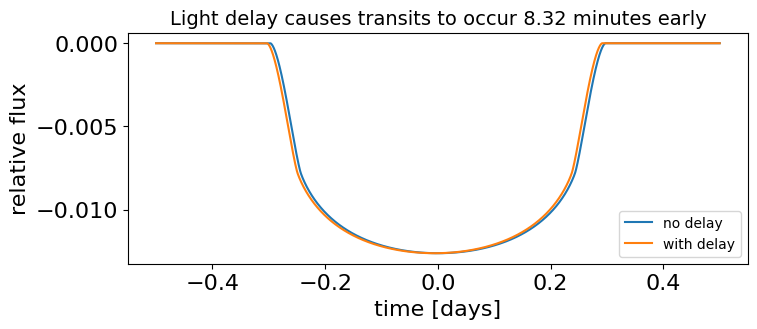

In [10]:
# Region around transit
t = np.linspace(-0.5, 0.5, 20000)

# No light delay
light_curve1 = (
    xo.LimbDarkLightCurve(0.5, 0.25)
    .get_light_curve(orbit=orbit, r=0.1, t=t)
    .eval()
)

# With light delay
light_curve2 = (
    xo.LimbDarkLightCurve(0.5, 0.25)
    .get_light_curve(orbit=orbit, r=0.1, t=t, light_delay=True)
    .eval()
)

# Plot!
fig = plt.figure(figsize=(8, 3))
plt.plot(t, light_curve1, label="no delay")
plt.plot(t, light_curve2, label="with delay")
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.legend(fontsize=10, loc="lower right")
_ = plt.title(
    "Light delay causes transits to occur 8.32 minutes early", fontsize=14
)